In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import numpy as np

# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc11 = nn.Linear(10, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x, label_one_hot):
        h0 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc11(label_one_hot))
        h2 = torch.add(h0, h1)
        h = F.relu(self.fc2(h2))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        h = F.sigmoid(self.fc6(h))
        return h

    def forward(self, x, label_one_hot):
        mu, log_var = self.encoder(x.view(-1, 784), label_one_hot)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

optimizer = optim.Adam(vae.parameters())

# reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# model train
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.float().cuda()
        label_one_hot = F.one_hot(label, 10).float().cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data, label_one_hot)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

# Model Test
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.float().cuda()
            label_one_hot = F.one_hot(label, 10).float().cuda()
            recon, mu, log_var = vae(data, label_one_hot)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(0, 30):
    train(epoch + 1)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 546.445679
Train Epoch: 1 [25600/60000 (43%)]	Loss: 192.477554
Train Epoch: 1 [51200/60000 (85%)]	Loss: 172.324356
====> Epoch: 1 Average loss: 198.4474
====> Test set loss: 171.9893
Train Epoch: 2 [0/60000 (0%)]	Loss: 177.980026
Train Epoch: 2 [25600/60000 (43%)]	Loss: 171.872772
Train Epoch: 2 [51200/60000 (85%)]	Loss: 166.217880
====> Epoch: 2 Average loss: 167.9198
====> Test set loss: 163.2707
Train Epoch: 3 [0/60000 (0%)]	Loss: 161.847412
Train Epoch: 3 [25600/60000 (43%)]	Loss: 162.312500
Train Epoch: 3 [51200/60000 (85%)]	Loss: 155.990997
====> Epoch: 3 Average loss: 160.8283
====> Test set loss: 158.0189
Train Epoch: 4 [0/60000 (0%)]	Loss: 161.152649
Train Epoch: 4 [25600/60000 (43%)]	Loss: 155.904770
Train Epoch: 4 [51200/60000 (85%)]	Loss: 157.974716
====> Epoch: 4 Average loss: 155.2682
====> Test set loss: 153.1276
Train Epoch: 5 [0/60000 (0%)]	Loss: 152.594040
Train Epoch: 5 [25600/60000 (43%)]	Loss: 145.612381
Train Epoch: 5 [51200/600

torch.Size([25, 1, 28, 28])

### Correct Labels

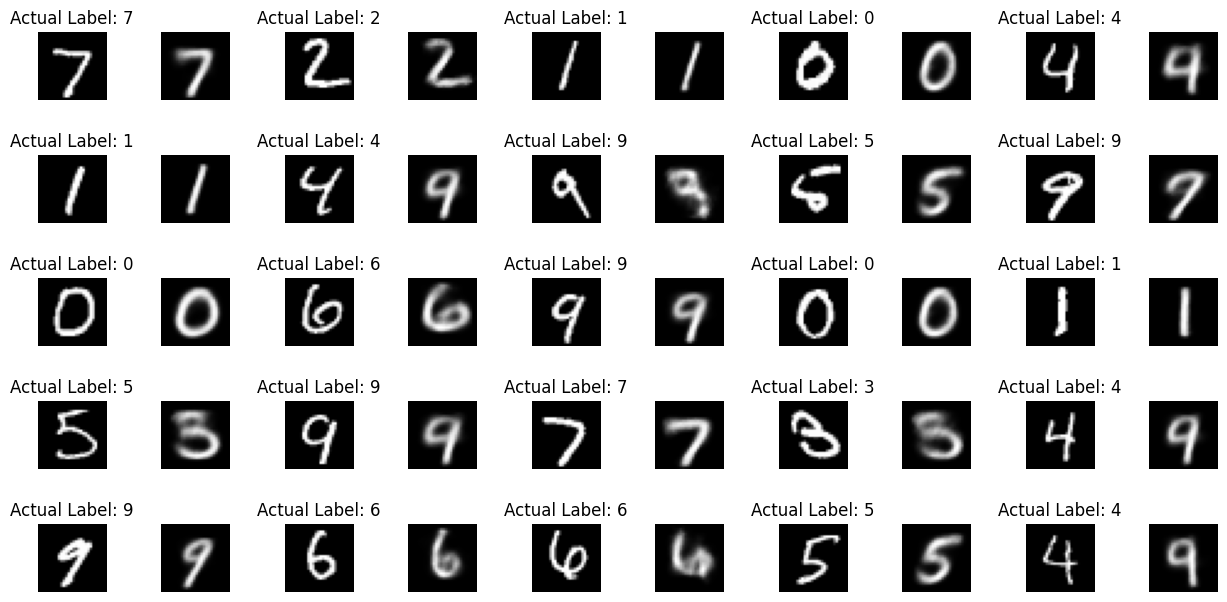

In [54]:
import random
import matplotlib.pyplot as plt
import torch

vae.eval()

with torch.no_grad():
    i = 0
    for data, label in val_loader:
        i += 1
        if i > 0:
            break

val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=25, shuffle=False)

vae.eval()

# Initialize a list to store original and predicted images
original_images = []
predicted_images = []

data = data.float().cuda()
label_one_hot_val = F.one_hot(label, 10).float().cuda()

recon_val, mu_val, log_var_val = vae(data, label_one_hot_val)

for d in range(25):
# # Append the original and predicted images to the lists
  original_images.append(data[d][0].cpu().numpy())
  predicted_images.append(recon_val.view(25, 1, 28, 28)[d].detach().cpu().numpy())

# Create a figure to stack original and predicted images with increased spacing between rows
fig, axes = plt.subplots(5, 10, figsize=(15, 7))

# Adjust the spacing between subplots, adding more space between rows (change hspace value)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.8)

for i in range(25):
    row = i // 5
    col = i % 5
    # Show original image
    axes[row, col * 2].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axes[row, col * 2].set_title(f"Actual Label: {label[i]}")
    # Check if predicted image has a valid shape
    if predicted_images[i][0].shape == (28, 28):
        axes[row, col * 2 + 1].imshow(predicted_images[i][0], cmap='gray')
    else:
        axes[row, col * 2 + 1].set_title("Invalid Shape")


# Remove axis labels from all subplots
for ax in axes.flatten():
    ax.axis('off')

plt.show()

### Incorrect Labels

In [60]:

# Print the original tensor and the new tensor
print("Original Tensor:")
print(label)

print("\nNew Tensor with Random Values:")
print(false_label)


Original Tensor:
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4])

New Tensor with Random Values:
tensor([8, 1, 1, 5, 3, 0, 6, 8, 0, 6, 5, 0, 9, 7, 8, 9, 1, 4, 2, 1, 3, 0, 1, 5,
        9])


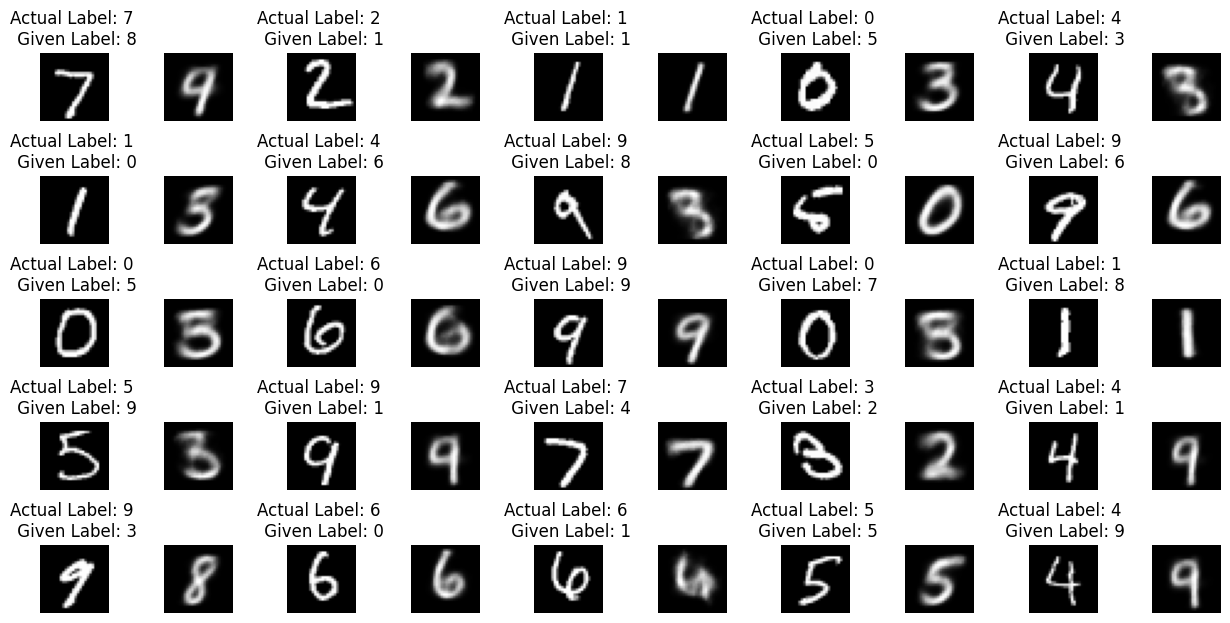

In [59]:
import random


# Initialize a list to store original and predicted images
original_images = []
predicted_images = []

# Create a new tensor with random values of the same type
false_label = torch.randint_like(label, low=0, high=10)  # Generates random integers between 0 and 9
false_label_one_hot_val = F.one_hot(false_label, 10).float().cuda()

recon_val, mu_val, log_var_val = vae(data, false_label_one_hot_val)

for d in range(25):
# # Append the original and predicted images to the lists
  original_images.append(data[d][0].cpu().numpy())
  predicted_images.append(recon_val.view(25, 1, 28, 28)[d].detach().cpu().numpy())

# Create a figure to stack original and predicted images with increased spacing between rows
fig, axes = plt.subplots(5, 10, figsize=(15, 7))

# Adjust the spacing between subplots, adding more space between rows (change hspace value)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.8)

for i in range(25):
    row = i // 5
    col = i % 5
    # Show original image
    axes[row, col * 2].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axes[row, col * 2].set_title(f"Actual Label: {label[i]} \n Given Label: {false_label[i]}")
    # Check if predicted image has a valid shape
    if predicted_images[i][0].shape == (28, 28):
        axes[row, col * 2 + 1].imshow(predicted_images[i][0], cmap='gray')
    else:
        axes[row, col * 2 + 1].set_title("Invalid Shape")


# Remove axis labels from all subplots
for ax in axes.flatten():
    ax.axis('off')

plt.show()
